<h1>DESAFIO INTELIVIX</h1>
<p>Análise de Sentimento</p>

<h2>Importando as Bibliotecas</h2>

In [38]:
import numpy as np
import pandas as pd
import matplotlib as plt
import warnings
import nltk
import csv
import os
import re
from sklearn.metrics import confusion_matrix, \
    classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import cross_val_predict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pandas import read_csv, concat
from sklearn.ensemble import VotingClassifier

<h2>Baixar WordNet </h2>
<p>Banco de dados léxico em inglês, usado posteriormente para auxiliar no pré-processamento dos dados.</p>

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\UPE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2>Ignorar <i>warnings</i>, para melhor visualização de resultados posteriomente.</h2>

In [36]:
warnings.filterwarnings("ignore")

<h2>Endereço da pasta onde o arquivo da base de dados se encontra</h2>

In [40]:
pasta = os.path.abspath(".") + "/Base/"

<h2>Pré-processamento dos dados</h2>
<p>Em pré-processamento, foram adotadas as técnicas: <b>Tokenização</b>, <b>Lematização</b> e <b>Remoção de <i>Stopwords<i/></b>. Uma filtragem e remoção de pontuações e caracteres especiais também foi realizada.</p>
</br>
<p> É importante ressaltar que daqui em diante, só foram consideradas duas das colunas disponíveis na base dados: <b>Texto</b> e <b>Sentimento</b>, pois as demais foram consideradas irrelevantes para a classificação. Uma vez que não apresentavam conteúdo que pudesse ajudar os algoritmos a classificar os textos.

In [39]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

resultadoLinha = []

df = pd.read_csv(pasta+"train.tsv",
                 sep='\t',
                 encoding="ISO-8859-1")

for i, row in df.iterrows():
    montaLinha = []

    # TOKENIZAÇÃO
    word_tokens = word_tokenize(row['Texto'])

    # LEMATIZAÇÃO
    lemmatized = list()
    for word in word_tokens:
        l2 = lemmatizer.lemmatize(word)
        lemmatized.append(l2)

    # STOP WORDS e REMOÇÃO DE ACENTOS
    filtered_sentence = []
    for w in lemmatized:
        if w not in stop_words:
            dict = {":": "", ".": "", ",": "", ";": "", "?": "",
                    "!": "", "'": "", ":": "", "$": "", "-": "",
                    "_": ""}
            regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))
            cont = regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], w)

            if(cont):
                filtered_sentence.append(w)

    if(filtered_sentence):
        montaLinha.insert(0, filtered_sentence)
        montaLinha.insert(1, row['Sentimento'])
        resultadoLinha.append(montaLinha)




  <h2>Salva a base pré-processada em arquivo CSV</h2>

In [41]:
with open(pasta + "base_pp.csv", 'wb') as csvbase:
    tagWriter = csv.writer(csvbase,
                           delimiter=',',
                           quoting=csv.QUOTE_MINIMAL)

    tagWriter.writerow(['Texto', 'Sentimento'])
    for resL in resultadoLinha:
        tagWriter.writerow(resL)

<h2>Classificação</h2>
<p>Para realizar a classificação, foram escolhidos os classificadores: Random Forest, Decision Tree e Multilayer Perceptron.
Além disto, o tipo de vectorização escolhida para realizar a tranformação de texto em uma matriz de ocorrências de token foi o HashingVectorizer.</p>

In [42]:
hv = HashingVectorizer(n_features=50, non_negative=True)

vec_clf = Pipeline([('vectorizer', hv)])

<h2>Quantidade de instâncias por classe</h2>
Foi constatado um desbalanceamento entre as classes da base de dados, conforme pode-se observar abaixo:

In [43]:
df = pd.read_csv(pasta + '/base_pp.csv', sep=",")

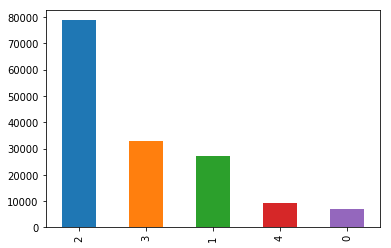

In [46]:
pd.value_counts(df['Sentimento']).plot.bar()

<h2>Conforme orientação prévia, o arquivo train.tst deveria ser dividido e utilizado para treino, teste e validação.</h2>
75% da base foi separada para treino e teste e 25% ficou para validação.

In [47]:
amostraBase = np.random.rand(len(df)) < 0.75
train = df[amostraBase]
test = df[~amostraBase]

<h2>Balanceamento com SMOTE</h2>
<p>Como a base está desbalanceada, conforme já ilustrado, decidi realizar os experimentos com e sem balanceamento artificial, a fim de comparar os resultados. É importante ressaltar que os resultados aqui analisados são referentes à validação e não a avaliação do treino.</p>

In [48]:
sm = SMOTE(random_state=123, n_jobs=-1)

X_train_original = vec_clf.fit_transform(train['Texto'])
y_train_original = train['Sentimento']

X_train_res, y_train_res = sm.fit_sample(X_train_original, y_train_original)

In [49]:
X_validacao = test['Texto']
y_validacao = test['Sentimento']

<h2>RANDOM FOREST</h2>

<h3>Base original (desbalanceada)</h3>

In [50]:
random_forest_clf = RandomForestClassifier(n_estimators=10,
                                           criterion='gini',
                                           max_depth=None,
                                           n_jobs=-1) 

In [51]:
y_rf_desbalanceada = cross_val_predict(random_forest_clf,
                                       X_train_original,
                                       y_train_original,
                                       cv=5, n_jobs=-1)

random_forest_clf.fit(X_train_original, 
                      y_train_original)

pipeline_random_forest_desbalanceada = Pipeline([('feats', FeatureUnion([
                                                    ('countvec', vec_clf)])),
                                                    ('clf', random_forest_clf)])
              
   

<h2>Validação - Base desbalanceada (Randon Forest)</h2>

In [52]:
predicao_random_forest_desbalanceada = pipeline_random_forest_desbalanceada.predict(X_validacao)

In [53]:
print(accuracy_score(y_validacao, predicao_random_forest_desbalanceada))

0.5653721182113569


In [54]:
print(classification_report(y_validacao, predicao_random_forest_desbalanceada))

             precision    recall  f1-score   support

          0       0.39      0.26      0.31      1722
          1       0.45      0.30      0.36      6960
          2       0.62      0.83      0.71     19595
          3       0.46      0.31      0.37      8211
          4       0.45      0.26      0.33      2290

avg / total       0.54      0.57      0.53     38778



In [55]:
print(confusion_matrix(y_validacao, predicao_random_forest_desbalanceada))

[[  441   528   608   128    17]
 [  463  2055  3918   472    52]
 [  142  1394 16328  1614   117]
 [   56   432  4687  2512   524]
 [   16   125   856   705   588]]


<h3>Base Balanceada - Random Forest</h3>

In [56]:
y_rf_balanceada = cross_val_predict(random_forest_clf,
                                       X_train_res,
                                       y_train_res,
                                       cv=5, n_jobs=-1)

random_forest_clf.fit(X_train_res, 
                      y_train_res)

pipeline_random_forest_balanceada = Pipeline([('feats', FeatureUnion([
                                                    ('countvec', vec_clf)])),
                                                    ('clf', random_forest_clf)])

<h2>Validação - Base Balanceada (Random Forest)</h2>

In [57]:
predicao_random_forest_balanceada = pipeline_random_forest_balanceada.predict(X_validacao)

In [58]:
print(accuracy_score(y_validacao, predicao_random_forest_balanceada))

0.521507040074269


In [59]:
print(classification_report(y_validacao, predicao_random_forest_balanceada))

             precision    recall  f1-score   support

          0       0.29      0.32      0.30      1722
          1       0.40      0.35      0.37      6960
          2       0.65      0.69      0.67     19595
          3       0.40      0.37      0.39      8211
          4       0.31      0.33      0.32      2290

avg / total       0.52      0.52      0.52     38778



In [60]:
print(confusion_matrix(y_validacao, predicao_random_forest_balanceada))

[[  558   577   390   145    52]
 [  686  2409  2915   734   216]
 [  449  2218 13446  2876   606]
 [  193   648  3473  3044   853]
 [   55   167   529   773   766]]


<h2>DECISION TREE</h2><br>
<h3>Base original (desbalanceada)</h3>

In [61]:
decision_tree_clf = DecisionTreeClassifier(criterion='entropy',
                                           splitter='best',
                                           max_depth=None)

In [62]:
y_dt_desbalanceada = cross_val_predict(decision_tree_clf,
                                       X_train_original,
                                       y_train_original,
                                       cv=5, n_jobs=-1)

decision_tree_clf.fit(X_train_original, 
                      y_train_original)

pipeline_decision_tree_desbalanceada = Pipeline([('feats', FeatureUnion([
                                                    ('countvec', vec_clf)])),
                                                    ('clf', decision_tree_clf)])

<h2>Validação - Base desbalanceada (Decision Tree)</h2>

In [63]:
predicao_decision_tree_desbalanceada = pipeline_decision_tree_desbalanceada.predict(X_validacao)

In [64]:
print(accuracy_score(y_validacao, predicao_decision_tree_desbalanceada))

0.5527102996544433


In [65]:
print(classification_report(y_validacao, predicao_decision_tree_desbalanceada))

             precision    recall  f1-score   support

          0       0.31      0.30      0.31      1722
          1       0.41      0.30      0.35      6960
          2       0.62      0.81      0.70     19595
          3       0.46      0.28      0.35      8211
          4       0.40      0.24      0.30      2290

avg / total       0.52      0.55      0.53     38778



In [66]:
print(confusion_matrix(y_validacao, predicao_decision_tree_desbalanceada))

[[  517   489   563   122    31]
 [  637  2122  3623   485    93]
 [  288  1758 15893  1490   166]
 [  155   605  4568  2340   543]
 [   54   159   848   668   561]]


<h3>Base Balanceada - Decision Tree</h3>

In [67]:
y_dt_balanceada = cross_val_predict(decision_tree_clf,
                                       X_train_res,
                                       y_train_res,
                                       cv=5, n_jobs=-1)

decision_tree_clf.fit(X_train_res, 
                      y_train_res)

pipeline_decision_tree_balanceada = Pipeline([('feats', FeatureUnion([
                                                    ('countvec', vec_clf)])),
                                                    ('clf', decision_tree_clf)])

In [68]:
predicao_decision_tree_balanceada = pipeline_decision_tree_balanceada.predict(X_validacao)

In [69]:
print(accuracy_score(y_validacao, predicao_decision_tree_balanceada))

0.5084841920676673


In [70]:
print(classification_report(y_validacao, predicao_decision_tree_balanceada))

             precision    recall  f1-score   support

          0       0.25      0.31      0.28      1722
          1       0.37      0.33      0.35      6960
          2       0.64      0.69      0.66     19595
          3       0.39      0.34      0.36      8211
          4       0.29      0.29      0.29      2290

avg / total       0.50      0.51      0.50     38778



In [71]:
print(confusion_matrix(y_validacao, predicao_decision_tree_balanceada))

[[  534   520   431   159    78]
 [  722  2275  2951   779   233]
 [  531  2384 13449  2671   560]
 [  240   812  3583  2802   774]
 [   91   202   592   747   658]]


<h2>MULTILAYER PERCEPTRON</h2><br>
<h3>Base original (desbalanceada)</h3>

In [72]:
mlp_clf = MLPClassifier(hidden_layer_sizes=100,
                        learning_rate='adaptive',
                        learning_rate_init=0.001)

In [73]:
y_mlp_desbalanceada = cross_val_predict(mlp_clf,
                                       X_train_original,
                                       y_train_original,
                                       cv=5, n_jobs=-1)

mlp_clf.fit(X_train_original, 
            y_train_original)

pipeline_mlp_desbalanceada = Pipeline([('feats', FeatureUnion([
                                       ('countvec', vec_clf)])),
                                       ('clf', mlp_clf)])

<h2>Validação - Base desbalanceada (Multilayer Perceptron)</h2>

In [74]:
predicao_mlp_desbalanceada = pipeline_mlp_desbalanceada.predict(X_validacao)

In [75]:
print(accuracy_score(y_validacao, predicao_mlp_desbalanceada))

0.5209912837175719


In [76]:
print(classification_report(y_validacao, predicao_mlp_desbalanceada))

             precision    recall  f1-score   support

          0       0.31      0.04      0.07      1722
          1       0.34      0.20      0.25      6960
          2       0.58      0.87      0.69     19595
          3       0.35      0.20      0.25      8211
          4       0.37      0.06      0.10      2290

avg / total       0.46      0.52      0.46     38778



In [77]:
print(confusion_matrix(y_validacao, predicao_mlp_desbalanceada))

[[   66   491   886   266    13]
 [   63  1392  4677   792    36]
 [   35  1230 16982  1287    61]
 [   38   746  5682  1630   115]
 [   10   286  1230   631   133]]


<h3>Base Balanceada - Multilayer Perceptron</h3>

In [78]:
y_mlp_balanceada = cross_val_predict(mlp_clf,
                                       X_train_res,
                                       y_train_res,
                                       cv=5, n_jobs=-1)

mlp_clf.fit(X_train_res, 
            y_train_res)

pipeline_mlp_balanceada = Pipeline([('feats', FeatureUnion([
                                    ('countvec', vec_clf)])),
                                    ('clf', mlp_clf)])

In [79]:
predicao_mlp_balanceada = pipeline_mlp_balanceada.predict(X_validacao)

In [80]:
print(accuracy_score(y_validacao, predicao_mlp_balanceada))

0.3860694208056114


In [81]:
print(classification_report(y_validacao, predicao_mlp_balanceada))

             precision    recall  f1-score   support

          0       0.15      0.31      0.20      1722
          1       0.25      0.24      0.24      6960
          2       0.67      0.48      0.56     19595
          3       0.27      0.31      0.29      8211
          4       0.15      0.34      0.21      2290

avg / total       0.46      0.39      0.41     38778



In [82]:
print(confusion_matrix(y_validacao, predicao_mlp_balanceada))

[[ 541  438  219  329  195]
 [1014 1655 1867 1649  775]
 [1292 2842 9428 4217 1816]
 [ 635 1359 2220 2577 1420]
 [ 182  309  349  680  770]]


<h2>ENSEMBLE - VOTING CLASSIFIER</h2><br>
<h3>Base original (desbalanceada)</h3>

In [83]:
voting_clf = VotingClassifier(estimators=[('RF', random_forest_clf), 
                                          ('DT', decision_tree_clf), 
                                          ('MLP', mlp_clf)], voting='soft')

y_voting_desbalanceada = cross_val_predict(voting_clf,
                                           X_train_original,
                                           y_train_original,
                                           cv=5, n_jobs=-1)

voting_clf.fit(X_train_original, 
               y_train_original)

pipeline_voting_desbalanceada = Pipeline([('feats', FeatureUnion([
                                                    ('countvec', vec_clf)])),
                                                    ('clf', voting_clf)])

<h2>Validação - Base desbalanceada (Ensemble - Voting Classifier)</h2>

In [85]:
predicao_voting_desbalanceada = pipeline_voting_desbalanceada.predict(X_validacao)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [86]:
print(accuracy_score(y_validacao, predicao_voting_desbalanceada))

0.5606013719119088


In [87]:
print(classification_report(y_validacao, predicao_voting_desbalanceada))

             precision    recall  f1-score   support

          0       0.35      0.24      0.29      1722
          1       0.44      0.28      0.35      6960
          2       0.62      0.83      0.71     19595
          3       0.46      0.29      0.36      8211
          4       0.40      0.26      0.31      2290

avg / total       0.53      0.56      0.53     38778



In [88]:
print(confusion_matrix(y_validacao, predicao_voting_desbalanceada))

[[  415   528   613   131    35]
 [  457  1979  3924   501    99]
 [  179  1383 16340  1520   173]
 [   99   440  4674  2420   578]
 [   31   129   881   664   585]]


<h3>Base Balanceada - Voting Classifier</h3>

In [89]:
y_voting_balanceada = cross_val_predict(voting_clf,
                                       X_train_res,
                                       y_train_res,
                                       cv=5, n_jobs=-1)

mlp_clf.fit(X_train_res, 
            y_train_res)

pipeline_voting_balanceada = Pipeline([('feats', FeatureUnion([
                                       ('countvec', vec_clf)])),
                                       ('clf', voting_clf)])

In [93]:
predicao_voting_balanceada = pipeline_voting_balanceada.predict(X_validacao)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [96]:
print(accuracy_score(y_validacao, predicao_voting_balanceada))

0.5606013719119088


In [97]:
print(classification_report(y_validacao, predicao_voting_balanceada))

             precision    recall  f1-score   support

          0       0.35      0.24      0.29      1722
          1       0.44      0.28      0.35      6960
          2       0.62      0.83      0.71     19595
          3       0.46      0.29      0.36      8211
          4       0.40      0.26      0.31      2290

avg / total       0.53      0.56      0.53     38778



In [98]:
print(confusion_matrix(y_validacao, predicao_voting_balanceada))

[[  415   528   613   131    35]
 [  457  1979  3924   501    99]
 [  179  1383 16340  1520   173]
 [   99   440  4674  2420   578]
 [   31   129   881   664   585]]
